![header](figures/DC_MapMed_OSE-banner.png)

***
**Authors:**  Datlas & IGE <br>
**Copyright:** 2022 Datlas & IGE <br>
**License:** MIT

<div class="alert alert-block alert-success">
    <h1><center>Quickstart</center></h1>
    <h5><center>This notebook provides a quickstart that illustrates the OI baseline on a small time period and its evaluation.</h5> 
</div> 





This Quickstart Guide presents a simple example of MapMed data challenge for mapping the Sea Surface Height from sparse real altimetry observations.

The methodology is based on an Observing System Experiment (OSE). The inputs data represent real altimeter observations (From CMEMS). A simple mapping algorithm (Optimal Interpolation) is used to produce the reconstructed SSH field from the sparse observations. Finally, a comparison between the reconstructed and an independent altimeter SSH fields is done to quantify the reconstruction scores. For saving computational time, the analysis in this demo is done for only 5 days.

The notebook is structured as follow: 

    1) Optimal interpolation principle
    2) Set up optimal interpolation parameters,
    3) Read observations,
    4) Run optimal interpolation 
    5) Save the results
    6) Statistical and spectral validations
    7) Display leaderboard metrics

In [1]:
import xarray as xr
import numpy
import warnings
import logging
import sys
import os
import pandas as pd
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

sys.path.append('..')

from src.mod_oi import *
from src.mod_inout import *
from src.mod_interp import *
from src.mod_stats import *
from src.mod_spectral import *
from src.mod_plot import *

<div class="alert alert-info" role="alert">

<h2> Set up optimal interpolation parameters </h2>

</div>

In [5]:
# OI Grid
lon_min = 295.                                           # domain min longitude
lon_max = 305.                                           # domain max longitude
lat_min = 33.                                            # domain min latitude
lat_max = 43.                                            # domain max latitude
is_circle = False
time_min = numpy.datetime64('2017-01-01')                # domain min time
time_max = numpy.datetime64('2017-01-31')                # domain max time
dx = 0.2                                                 # zonal grid spatial step (in degree)
dy = 0.2                                                 # meridional grid spatial step (in degree)
dt = numpy.timedelta64(1, 'D')                           # temporal grid step

glon = numpy.arange(lon_min, lon_max + dx, dx)           # output OI longitude grid
glat = numpy.arange(lat_min, lat_max + dy, dy)           # output OI latitude grid
gtime = numpy.arange(time_min, time_max + dt, dt)        # output OI time grid

# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 7.                                                  # Temporal decorrelation scale (in days)
noise = 0.05                                             # Noise level (5%)

# Statistical validation parameters
bin_lat_step = 1.                                        # latitude bin step in degree
bin_lon_step = 1.                                        # longitude bin step in degree
bin_time_step = '1D'                                     # time bin step '1D' == 1day (see pandas resample freq.)
output_directory = './results'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
output_filename = f'{output_directory}/stat_OSE_BASELINE_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'
output_filename_timeseries = f'{output_directory}/stat_timeseries_OSE_BASELINE_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

# Spectral validation parameter
# C2 parameter
delta_t = 0.9434                                         # Cryosat-2 averaged deltat in sample in s
velocity = 6.77                                          # Cryosat-2 ground velocity in km/s
delta_x = velocity * delta_t
lenght_scale = 1000                                      # segment length scale in km
output_filename_spectrum = f'{output_directory}/psd_OSE_BASELINE_v2_{time_min}_{time_max}_{lon_min}_{lon_max}_{lat_min}_{lat_max}.nc'

<div class="alert alert-info" role="alert">

<h2> Retrieve and read the observations </h2>

</div>

In [6]:
my_aviso_session = rq.Session()
my_aviso_session.auth = ("<AVISO_LOGIN>", "<AVISO_PWD>")
url_alongtrack = 'https://tds.aviso.altimetry.fr/thredds/dodsC/2021a-SSH-mapping-OSE-along-track-data'
url_map = 'https://tds.aviso.altimetry.fr/thredds/dodsC/2021a-SSH-mapping-OSE-grid-data'

In [7]:
inputs = [f'{url_alongtrack}/dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{url_alongtrack}/dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{url_alongtrack}/dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{url_alongtrack}/dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{url_alongtrack}/dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{url_alongtrack}/dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc'] 

In [8]:
# Define outputs
output_directory = './results/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)  
output_oi = f'{output_directory}/OSE_ssh_mapping_BASELINE.nc'

<div class="alert alert-info" role="alert">

<h2> Perform optimal interpolation </h2>

</div>

In [9]:
%%time
# set OI param & grid
ds_oi1_param = oi_param(Lx, Ly, Lt, noise)
ds_oi1_grid = oi_grid(glon, glat, gtime)
# Read input obs + discard a bit...
coarsening = {'time': 5}
#ds_oi1_obs = read_obs(inputs, ds_oi1_grid, ds_oi1_param, coarsening)
ds_oi1_obs = read_obs_from_aviso(inputs, my_aviso_session, ds_oi1_grid, ds_oi1_param, coarsening)
# Run OI (take 1h on my laptop)
for it in range(len(gtime)):
    oi_core(it, ds_oi1_grid, ds_oi1_param, ds_oi1_obs)

INFO:root:     Set OI params...
INFO:root:     Set OI grid...
INFO:root:     Reading observations from aviso...


CPU times: user 9min 38s, sys: 32.4 s, total: 10min 11s
Wall time: 29min 29s


<div class="alert alert-info" role="alert">

<h2> Save the results </h2>

</div>

In [10]:
url_ds_mdt = f'{url_map}/mdt.nc'
ds_oi1_grid = reformate_oi_output(ds_oi1_grid, url_ds_mdt, my_aviso_session)
ds_oi1_grid.to_netcdf(output_oi)

<div class="alert alert-info" role="alert">

<h2>  Statistical & Spectral Validations </h2>

</div>

### Read independent L3 datasets

In [11]:
# independent along-track
alontrack_independent_dataset = f'{url_alongtrack}/dt_gulfstream_c2_phy_l3_20161201-20180131_285-315_23-53.nc'
# Read along-track
ds_alongtrack = read_l3_dataset_from_aviso(alontrack_independent_dataset,
                                           my_aviso_session,
                                           lon_min=lon_min, 
                                           lon_max=lon_max, 
                                           lat_min=lat_min, 
                                           lat_max=lat_max, 
                                           time_min=time_min, 
                                           time_max=time_max)
ds_alongtrack

<xarray.Dataset>
Dimensions:         (time: 4430)
Coordinates:
  * time            (time) datetime64[ns] 2017-01-01T08:08:42.012641024 ... 2...
    longitude       (time) float64 297.4 297.4 297.4 297.4 ... 297.9 297.9 297.9
    latitude        (time) float64 33.03 33.09 33.15 33.2 ... 33.17 33.11 33.05
Data variables:
    cycle           (time) float64 88.0 88.0 88.0 88.0 ... 89.0 89.0 89.0 89.0
    track           (time) float64 701.0 701.0 701.0 701.0 ... 716.0 716.0 716.0
    dac             (time) float32 -0.1647 -0.1648 -0.165 ... -0.0098 -0.0104
    lwe             (time) float32 0.003 0.003 0.003 ... -0.004 -0.004 -0.004
    mdt             (time) float32 0.593 0.592 0.591 0.59 ... 0.588 0.589 0.59
    ocean_tide      (time) float64 -0.3407 -0.3413 -0.342 ... -0.3279 -0.3269
    sla_filtered    (time) float32 -0.136 -0.16 -0.18 ... 0.155 0.159 0.164
    sla_unfiltered  (time) float32 -0.151 -0.119 -0.158 ... 0.174 0.15 0.127
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2019-03-28T08:33:58Z
    date_issued:                     2019-03-28T08:33:58Z
    date_modified:                   2019-03-28T08:33:58Z
    geospatial_lat_max:              82.252703
    geospatial_lat_min:              -69.84683
    geospatial_lat_resolution:       0.05649700000000024
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.997542
    geospatial_lon_min:              0.010983
    geospatial_lon_resolution:       0.006772999999999474
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2019-03-28T08:33:58Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Cryosat-2
    processing_level:                L3
    product_version:                 2019
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                6.2_DUACS_DT2018_baseline
    source:                          Cryosat-2 measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H43M4.754863S
    time_coverage_end:               2016-01-01T23:11:03Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:27:58Z
    title:                           DT Cryosat-2 Global Ocean Along track SS...
    _NCProperties:                   version=2,netcdf=4.7.4,hdf5=1.10.6

### Interpolate maps onto alongtrack dataset

In [12]:
time_alongtrack, lat_alongtrack, lon_alongtrack, ssh_alongtrack, ssh_map_interp = interp_on_alongtrack(output_oi, 
                                                                                                       ds_alongtrack,
                                                                                                       lon_min=lon_min, 
                                                                                                       lon_max=lon_max, 
                                                                                                       lat_min=lat_min, 
                                                                                                       lat_max=lat_max, 
                                                                                                       time_min=time_min, 
                                                                                                       time_max=time_max,
                                                                                                       is_circle=is_circle)

### Compute statistical metrics

In [13]:
leaderboard_nrmse, leaderboard_nrmse_std = compute_stats(time_alongtrack, 
                                                         lat_alongtrack, 
                                                         lon_alongtrack, 
                                                         ssh_alongtrack, 
                                                         ssh_map_interp, 
                                                         bin_lon_step,
                                                         bin_lat_step, 
                                                         bin_time_step,
                                                         output_filename,
                                                         output_filename_timeseries)

INFO:root:  Results saved in: ./results/stat_OSE_BASELINE_2017-01-01_2017-01-31_295.0_305.0_33.0_43.0.nc
INFO:root: 
INFO:root:  Results saved in: ./results/stat_timeseries_OSE_BASELINE_2017-01-01_2017-01-31_295.0_305.0_33.0_43.0.nc
INFO:root: 
INFO:root:  MEAN RMSE Score = 0.8192215372602984
INFO:root: 
INFO:root:  STD RMSE Score = 0.17453525540624676


### Plot statistical metrics

In [14]:
plot_spatial_statistics(output_filename)

:Image   [lon,lat]   (rmse)

In [15]:
plot_temporal_statistics(output_filename_timeseries)

:Layout
   .Curve.I  :Curve   [time]   (rms)
   .Curve.II :Curve   [time]   (count)

### Compute spectral metrics

In [16]:
compute_spectral_scores(time_alongtrack, 
                        lat_alongtrack, 
                        lon_alongtrack, 
                        ssh_alongtrack, 
                        ssh_map_interp, 
                        lenght_scale,
                        delta_x,
                        delta_t,
                        output_filename_spectrum)

INFO:root:  Results saved in: ./results/psd_OSE_BASELINE_v2_2017-01-01_2017-01-31_295.0_305.0_33.0_43.0.nc


### Plot spectral metric

INFO:root: 
INFO:root:  Minimum spatial scale resolved = 133km


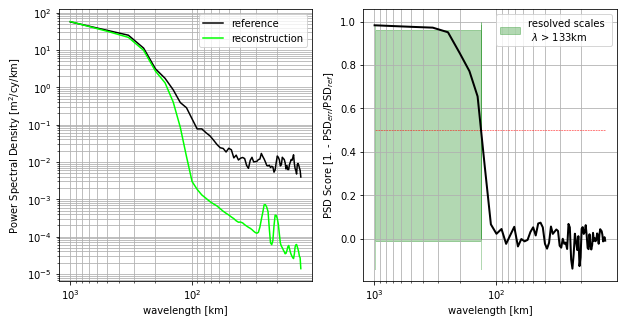

In [17]:
leaderboard_psds_score = plot_psd_score(output_filename_spectrum)

<div class="alert alert-info" role="alert">

<h2>  Display leaderboard metrics </h2>

</div>

In [18]:
# Print leaderboard
data = [['BASELINE', 
         leaderboard_nrmse, 
         leaderboard_nrmse_std, 
         int(leaderboard_psds_score),
        'Covariances BASELINE OI',
        'example_eval_baseline.ipynb']]
Leaderboard = pd.DataFrame(data, 
                           columns=['Method', 
                                    "µ(RMSE) ", 
                                    "σ(RMSE)", 
                                    'λx (km)',  
                                    'Notes',
                                    'Reference'])
print("Summary of the leaderboard metrics:")
Leaderboard
print(Leaderboard.to_markdown())

Summary of the leaderboard metrics:


ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.